# Let's create a clean DEM for the Adventdalen to Bjørndalen area

# Only Clément can run this notebook, read:

The raw DEM files are heavy and are not in the shared folder. If you want to run this, ask Clément or download from the link bellow (NPI).

In [1]:
import rioxarray as rxr
from rioxarray.merge import merge_arrays
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D
import geopandas as gpd
from tqdm import tqdm

import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

import platform
if platform.system() =='Linux': path='/home/clc/Desktop/AGF350_data/Data/DEM/NPI_DEM/'
elif platform.system() =='Windows': path='../Data/'

terrain = plt.get_cmap('terrain')
terrain_truncated = truncate_colormap(terrain, 0.2, .9)

From https://data.npolar.no/dataset/dce53a47-c726-4845-85c3-a65b46fe2fea

I identified 6 DEM files:

- S0_DTM2_5_2009_13835_33_Longyearbyenomr
- S0_DTM2_5_2011_25162_33_Longyearbyenomr
- S0_DTM5_2009_13822_33
- S0_DTM5_2009_13833_33
- S0_DTM5_2009_13835_33
- S0_DTM5_2011_25162_33
- S0_DTM5_2011_25163_33

In [2]:
if False:
    fnames = ! ls {path}*/*.tif
    for fn in fnames:
        ds = rxr.open_rasterio(fn).rio.reproject('EPSG:4326')
        print(fn.split('/')[-1], ds.x.data.min(), ds.x.data.max(), ds.y.data.min(), ds.y.data.max())

In [3]:
DEM1 = rxr.open_rasterio(path+'NP_S0_DTM2_5_2009_13835_33_Longyearbyenomr/S0_DTM2_5_2009_13835_33_Longyearbyenomr.tif').squeeze() 
# Most recent Longyearbyen area DEM
DEM_paths = [path+'NP_S0_DTM2_5_2011_25162_33_Longyearbyenomr/S0_DTM2_5_2011_25162_33_Longyearbyenomr.tif',
             path+'NP_S0_DTM5_2011_25162_33/S0_DTM5_2011_25162_33.tif',
             path+'NP_S0_DTM5_2011_25163_33/S0_DTM5_2011_25163_33.tif',
             path+'NP_S0_DTM5_2009_13835_33/S0_DTM5_2009_13835_33.tif',
             path+'NP_S0_DTM5_2009_13833_33/S0_DTM5_2009_13833_33.tif',
             path+'NP_S0_DTM5_2009_13822_33/S0_DTM5_2009_13822_33.tif'] #then the following ones, in order

print('Resoluttions of DEM1 (x, y): ')
print(np.unique(np.diff(DEM1.x.data)))
print(np.unique(np.diff(DEM1.y.data)))
#print('Resoluttions of DEM2 (x, y): ')
#print(np.unique(np.diff(DEM2.x.data)))
#print(np.unique(np.diff(DEM2.y.data)))

DEM1 = DEM1.rio.reproject('EPSG:4326')
#DEM2 = DEM2.rio.reproject('EPSG:4326')
DEM1 = xr.where(DEM1<-100, np.nan, DEM1)

Resoluttions of DEM1 (x, y): 
[2.5]
[-2.5]


## What do they look like?

(15.2, 16.2)

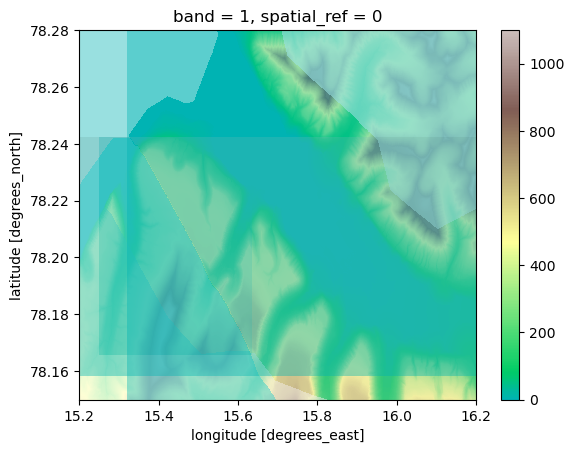

In [8]:
fig,ax = plt.subplots()
DEM1.plot(ax=ax, cmap=terrain_truncated, vmin=0, vmax=1100)
for fn in DEM_paths:
    DEM_ = rxr.open_rasterio(fn).rio.reproject('EPSG:4326').rio.clip_box(
                minx=15.2,
                miny=78.11,
                maxx=16.4,
                maxy=78.55,
            ).plot(ax=ax, cmap=terrain_truncated, vmin=0, vmax=1100, add_colorbar=False, alpha=.4)
ax.set_ylim(78.15, 78.28)
ax.set_xlim(15.2, 16.2)


# Let's interpolate the low-res DEM on the high-res grid

I want to use rioxarray's reproject_match function. For that, I first need to increase the extent of DEM1 such that is spans further west, including Bjørndalen. 

DEM1 has a resolution of 2.5m, and it needs to be expanded about 2.5km to the west, so let's add 1000 cells to the left.

In [5]:
n_new_columns_left = 1000
n_new_columns_right = 500

# Calculate the spacing between x coordinates
x_spacing = DEM1.x[1] - DEM1.x[0]

# Create new x-coordinates for the additional columns
new_x_coords_left = np.arange(DEM1.x[0] - n_new_columns_left * x_spacing, DEM1.x[0], x_spacing)
new_x_coords_right = np.arange(DEM1.x[-1], DEM1.x[-1] + n_new_columns_right * x_spacing, x_spacing)

# Create a DataArray for the new columns, filled with NaN
new_columns_left = xr.DataArray(
    data=np.full((DEM1.shape[0], n_new_columns_left), np.nan),  # Shape: (y, x_new)
    dims=["y", "x"],
    coords={
        "y": DEM1.y,                 # Keep the same y-coordinates
        "x": new_x_coords_left            # Add the new x-coordinates
    },
    attrs=DEM1.attrs                # Use the same attributes as the original
)

new_columns_right = xr.DataArray(
    data=np.full((DEM1.shape[0], n_new_columns_right), np.nan),  # Shape: (y, x_new)
    dims=["y", "x"],
    coords={
        "y": DEM1.y,                 # Keep the same y-coordinates
        "x": new_x_coords_right            # Add the new x-coordinates
    },
    attrs=DEM1.attrs                # Use the same attributes as the original
)

# Concatenate the new columns to the original DataArray
expanded_DEM1 = xr.concat([new_columns_left, DEM1, new_columns_right], dim="x").rio.write_crs('EPSG:4326')

/home/clc/micromamba/envs/rxr/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


### Reproject all the secondary DEMs onto the expanded DEM1

In [9]:
DEM_f = expanded_DEM1.copy() #start the final DEM with the expanded original DEM

for fn in tqdm(DEM_paths):
    DEM_ = rxr.open_rasterio(fn).rio.reproject('EPSG:4326').rio.clip_box(
                minx=15.2,
                miny=78.11,
                maxx=16.4,
                maxy=78.55,
            ).rio.reproject_match(expanded_DEM1) # load and reproject the new DEM
    DEM_ = xr.where(DEM_<-100, np.nan, DEM_)
    DEM_ = xr.where(DEM_>5000, np.nan, DEM_)
    DEM_f = xr.where(np.isnan(DEM_f), DEM_, DEM_f)
    # Wherever our final DEM had nans, pull the values from the new DEM (thus the order above)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:26<00:00,  4.36s/it]


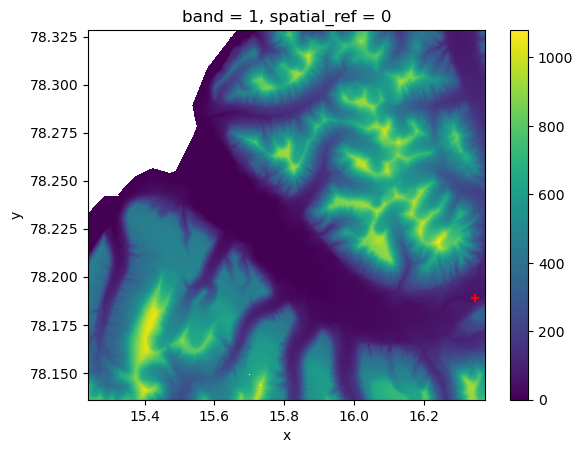

In [11]:
DEM_f = DEM_f.where(DEM_f>-100).where(DEM_f<10000)
fig,ax = plt.subplots()
DEM_f.plot(ax=ax)
ax.scatter(16.34596, 78.18879, marker='+', c='r')


## Brilliant! Save it

In [19]:
DEM_f.squeeze().transpose('y', 'x').rio.to_raster(path+'DEM_AGF350.tif')

# Pulling the elevation of the locations of our instruments

In [13]:
stations = pd.read_csv(path+'instrument_textbook_BLcourse_spring2025(BL instruments).csv', skipfooter=7)
stations

/tmp/ipykernel_62644/686074218.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  stations = pd.read_csv(path+'instrument_textbook_BLcourse_spring2025(BL instruments).csv', skipfooter=7)


,Station name,Category,Setup by group,Quantities measured,LAT (dec deg),LON (dec deg),elevation from GPS (masl),elevation from DEM (masl),Radiometer height(m),Th height (m),Anemometer height (m),CEB orientation (Tg),Setup time (UTC),Comments
0,Layla,AWS-P,3,"T, Ws, Wd, Tg, P",78.172686,16.010102,186 (NOT ACCURATE),NaN,NaN,1.820,2.09,NE,1/26/2025 11:25,NaN
1,TH3,Tinytag,3,"T, Rh",78.181669,15.908088,181 (NOT ACCURATE),NaN,NaN,1.400,NaN,NaN,1/26/2025 12:30,NaN
2,TH2,Tinytag,3,"T, Rh",78.212169,15.756418,160 (NOT ACCURATE),NaN,NaN,1.650,NaN,NaN,1/26/2025 12:45,NaN
3,Tom Joad,AWS,3,"T, Ws, Wd, Tg",78.226178,15.650295,NaN,NaN,NaN,1.900,2.21,N,1/26/2025 14:30:00 PM,NaN
4,Rosanna,AWS-P,3,"T, Ws, Wd, Tg, P",78.239350,15.749290,NaN,NaN,NaN,1.680,2.05,NE,1/27/2025 10:30,NaN
5,TH5,Tinytag,3,"T, Rh",78.223609,15.797014,NaN,NaN,NaN,1.650,NaN,NaN,1/27/2025 11:10,NaN
6,Bette Davis,AWS,3,"T, Ws, Wd, Tg",78.213555,15.857184,53 (NOT ACCURATE),NaN,NaN,1.700,2.08,N,1/27/2025 12:10,NaN
7,TH6,Tinytag,3,"T, Rh",78.197500,15.959215,72 (NOT ACCURATE),NaN,NaN,1.570,NaN,NaN,1/27/2025 13:30:00 PM,NaN
8,Mrs Robinson,AWS,3,"T, Ws, Wd, Tg",78.192157,16.029810,76 (NOT ACCURATE),NaN,NaN,1.780,2.09,W,1/27/2025 13:40:00 PM,NaN
9,TH1,TinyTag,1,"T, Rh",78.240911,15.354190,265 (NOT ACCURATE),NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
elevation_stations = []

DEM_LAT, DEM_LON = np.meshgrid(DEM_f.x.data, DEM_f.y.data)

for _lat,_lon in zip(stations['LON (dec deg)'], stations['LAT (dec deg)']):
    idx = np.unravel_index(np.argmin(np.sqrt(  (DEM_LAT-_lat)**2 + (DEM_LON-_lon)**2)), DEM_LAT.shape)
    elevation_stations.append(DEM_f.data[idx])

In [18]:
for _ in elevation_stations:
    print(_)

28.177753448486328
20.887054443359375
0.9885972738265991
0.5199999809265137
1.4011038541793823
3.625657081604004
4.366096496582031
10.850309371948242
17.301265716552734
27.48442840576172
2.599311590194702
2.599311590194702
2.599311590194702
2.716461658477783
2.716461658477783
22.359294891357422
22.359294891357422
22.359294891357422
2.1990091800689697
40.619693756103516
40.619693756103516
40.619693756103516
40.619693756103516
40.619693756103516
40.619693756103516
40.619693756103516
40.619693756103516
40.619693756103516
40.619693756103516
